In [1]:
import pacpy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Jesteśmy w folderze `notebooks` teraz. Korzystamy z "magic commands" aby wyjść poziom wyżej i wejść do folderu `SET po db`, gdzie są przetworzone przez `eegDb` dane.

In [2]:
%cd ..

c:\Users\Ola\Dropbox\PAC & DIAMENTY


In [3]:
%cd "SET po db"

c:\Users\Ola\Dropbox\PAC & DIAMENTY\SET po db


In [4]:
%ls

 Wolumin w stacji C nie ma etykiety.
 Numer seryjny woluminu: 1E29-5405

 Katalog: c:\Users\Ola\Dropbox\PAC & DIAMENTY\SET po db

2016-01-08  15:33    <DIR>          .
2016-01-08  15:33    <DIR>          ..
2016-01-08  15:31        20˙576˙000 D19_baseline.fdt
2016-01-08  15:31         1˙163˙856 D19_baseline.set
               2 plik(˘w)         21˙739˙856 bajt˘w
               2 katalog(˘w)  404˙972˙576˙768 bajt˘w wolnych


Powyżej sprawdziliśmy zawartość folderu `SET po db` - mamy jeden plik (ale jaki piękny!). Jeden plik w sensie eeglabowym - parę `.set` i `.fdt`. Najpierw wczytujemy `.set` - zawiera różne metainformacje, między innymi ilość kanałów, próbek w epoce i epok. Potrzebujemy tych informacji, aby poprawnie przeformatować wczytane z dysku dane (przechowywane w pliku `.fdt`)

In [5]:
from scipy.io import loadmat

In [6]:
setfile = loadmat('D19_baseline.set')
eeg = setfile['EEG']

Potrzebne informacje znajdziemy w polach "nbchan", "pnts" i "trials":

In [7]:
dims = [eeg[k][0,0][0,0] for k in ['nbchan', 'pnts', 'trials']]
dims

[64, 125, 643]

### Wczytujemy dane eeg
Teraz możemy już wczytać dane eeg z pliku `.fdt`. Sprawdzamy też jaką mają długość. Dane na początku są ciurkiem.

In [8]:
import numpy as np
data = np.fromfile('D19_baseline.fdt', dtype=np.float32)
print(data.shape)

(5144000,)


Sprawdzamy czy jak przemnożymy przez siebie rozmiar kolejnych wymiarów (informacja pobrana wcześniej z pliku `.set`) to dostajemy długośc wczytanych przez nas danych. To tylko taki safety check.

In [9]:
np.prod(dims)

5144000

Przekształcamy dane na poepokowany format. Pamiętamy o tym, że chcemy je formatować w kolejności Fortranowej (idąc wzdłuż kolumn)

In [10]:
data = data.reshape(dims, order='F')

Wyświetlamy dwie epoki (okienka) aby sprawdzić czy sygnał jest ok.

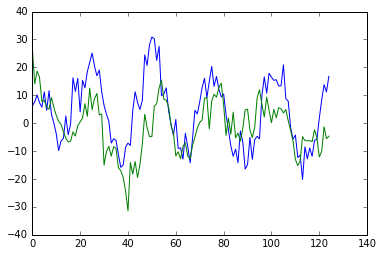

In [11]:
plt.plot(data[22,:,5:7])

Wszysko ok, ale do naszych zastosowań (szczególnie filtrowania) potrzebujemy danych ciągłych. Przekształcamy `data` jeszcze raz.

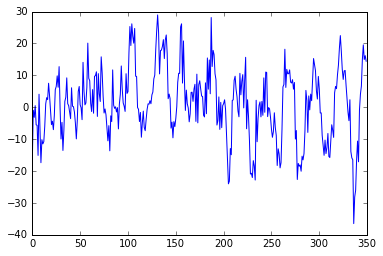

In [12]:
# reshape to 2D
data_cnt = data.reshape([dims[0], np.prod(dims[1:])], order='F')
plt.plot(data_cnt[22,:350])

### Filtrowanie
Pierwszy krok analizy PAC to przefiltrowanie danych, wczytujemy funkcje pomocnicze z `pacpy.filt` (faktycznie całe filtrowanie jest w `scipy.signal`)

In [13]:
from pacpy.filt import firf

Filtrujemy dane korzystając z funkcji `firf` (którą powyżej importujemy). Podajemy 23 kanał, zakres filtrowania (7 - 9 Hz), czestotliwość próbkowania oraz długość filtra (w cyklach najniższej oscylacji). Następnie plotujemy przefiltrowany sygnał.

In [16]:
flt = firf(data_cnt[22, :], (7,9), fs=250, w=3)

(-40, 30)

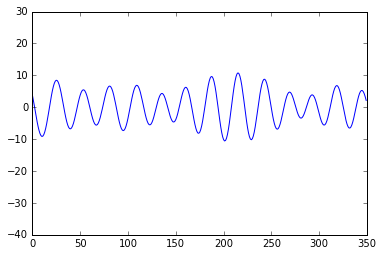

In [18]:
plt.plot(flt[:350])
plt.ylim([-40, 30])

Zestawienie sygnału przed filtrowaniem i po:

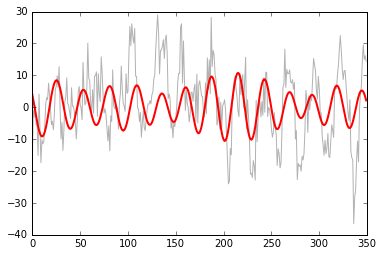

In [31]:
plt.plot(data_cnt[22, :350], color='k', alpha=0.3)
plt.plot(flt[:350], color='r', lw=2)

### Transformata hilberta
Wykorzystujemy transformatę hilberta by dostać się do wartości amplitudy (obwiedni) oraz fazy.

In [19]:
from scipy.signal import hilbert

In [20]:
hlb = hilbert(flt)

Warto zwrócić uwagę, że przetransformowane dane zawierają część urojoną. W ten sposób kodujemy amplitudę i fazę w jednej wartości (długość wektora w przestrzeni wartości rzeczywistych i urojonych to amplituda, kąt to natomiast faza).

In [21]:
hlb[:10]

array([ 3.94875999-3.1608002j ,  2.36549523+3.73736537j,
        0.65681412+3.89619275j, -1.10781759+5.77427662j,
       -2.85479516+5.20986872j, -4.50965873+5.54586396j,
       -6.00046806+4.31776623j, -7.26117071+3.69723167j,
       -8.23475335+1.96125316j, -8.87605998+0.74981749j])

In [22]:
amplitude = np.abs(hlb)
phase = np.angle(hlb)

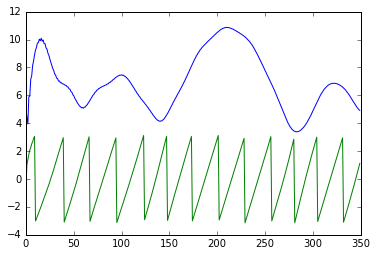

In [23]:
plt.plot(amplitude[:350])
plt.plot(phase[:350])

Wyświetlamy teraz przefiltrowany sygnał + obwiednię

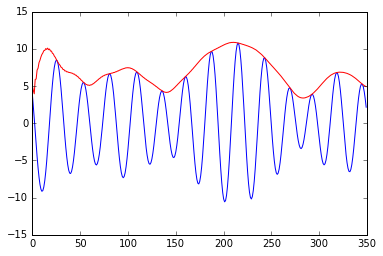

In [25]:
plt.plot(flt[:350])
plt.plot(amplitude[:350], 'r')

A teraz przefiltrowany sygnał i fazę z hilberta:

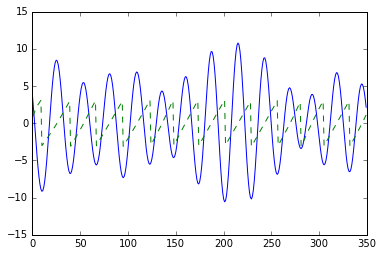

In [26]:
plt.plot(flt[:350])
plt.plot(phase[:350], '--g')

### Wczytujemy informacje o wyrzuconych częściach sygnału
Potrzebujemy jeszcze tylko wyrzucić z sygnału czas w którym występują artefakty. Dane te są w innym folderze - przemieszczamy się tam najpierw.

In [27]:
%cd ..\SET

c:\Users\Ola\Dropbox\PAC & DIAMENTY\SET


In [28]:
%ls

 Wolumin w stacji C nie ma etykiety.
 Numer seryjny woluminu: 1E29-5405

 Katalog: c:\Users\Ola\Dropbox\PAC & DIAMENTY\SET

2016-01-08  01:22    <DIR>          .
2016-01-08  01:22    <DIR>          ..
2015-12-28  17:26        19˙977˙472 D11_baseline.fdt
2015-12-28  17:26           423˙056 D11_baseline.set
2015-12-28  17:26        20˙201˙472 D16_baseline.fdt
2015-12-28  17:26           426˙440 D16_baseline.set
2015-12-28  17:26        19˙949˙056 D17_baseline.fdt
2015-12-28  17:26           422˙520 D17_baseline.set
2015-12-28  17:26        20˙585˙472 D19_baseline.fdt
2016-01-08  01:22                89 D19_baseline.rej
2015-12-28  17:26           432˙984 D19_baseline.set
               9 plik(˘w)         82˙418˙561 bajt˘w
               2 katalog(˘w)  404˙972˙146˙688 bajt˘w wolnych


Widzimy plik `D19_baseline.rej` - to własnie informacja o zaznaczeniach wykresportowanych z `eegDb`. Wczytujemy te informacje z wykorzystaniem biblioteki `pandas` - korzystamy z funkcji `read_table` informując ją, że separator w pliku to tab (`\t`)

In [29]:
import pandas as pd
df = pd.read_table('D19_baseline.rej', sep='\t')
df.head()

,reject,maybe
0,17,126
1,18,127
2,105,128
3,106,166
4,107,505


Wybieramy tylko zaznaczenia typu `reject` - reszty nie warto wyrzucać.

In [30]:
ind = df["reject"] > 0
rej = df.loc[ind, "reject"]
rej

0     17
1     18
2    105
3    106
4    107
5    108
Name: reject, dtype: int64

### Wyrzucamy fragmenty danych z artefaktami (CDN)